# This notebook contains the final figures for the SILVR paper

In [8]:
import pandas as pd

df = pd.read_csv("experiments/data_all.csv")
len(df)

7028

In [9]:
print(len(df[df["auto3d_rmsd"].notna()]))
print(len(df[df["is_fragmented"]==False]))
print(len(df[df["auto3d_rmsd"].notna()])/len(df[df["is_fragmented"]==False]))

4481
4597
0.9747661518381553


In [10]:
from matplotlib import pyplot as plt

def get_data_to_plot(df, exps, metric):
    make_100x = True
    ignore_nan = True
    plotting_data = []
    
    #labels = []
    
    for exp in exps:
        if ignore_nan:
            metric_value = df[(df["exp_id"] == exp) & df[metric].notna()][metric]
        else:
            metric_value = df[df["exp_id"] == exp][metric]
        plotting_data.append(metric_value)
        
        #labels.append(str(df[df["exp_id"] == exp]["silvr"].iloc[0]*100))
    

    return plotting_data


def get_plot_labels(df, exps, make_100x=True):
    labels = []
    for exp in exps:
        labels.append(str(df[df["exp_id"] == exp]["silvr"].iloc[0]*100))
    return labels

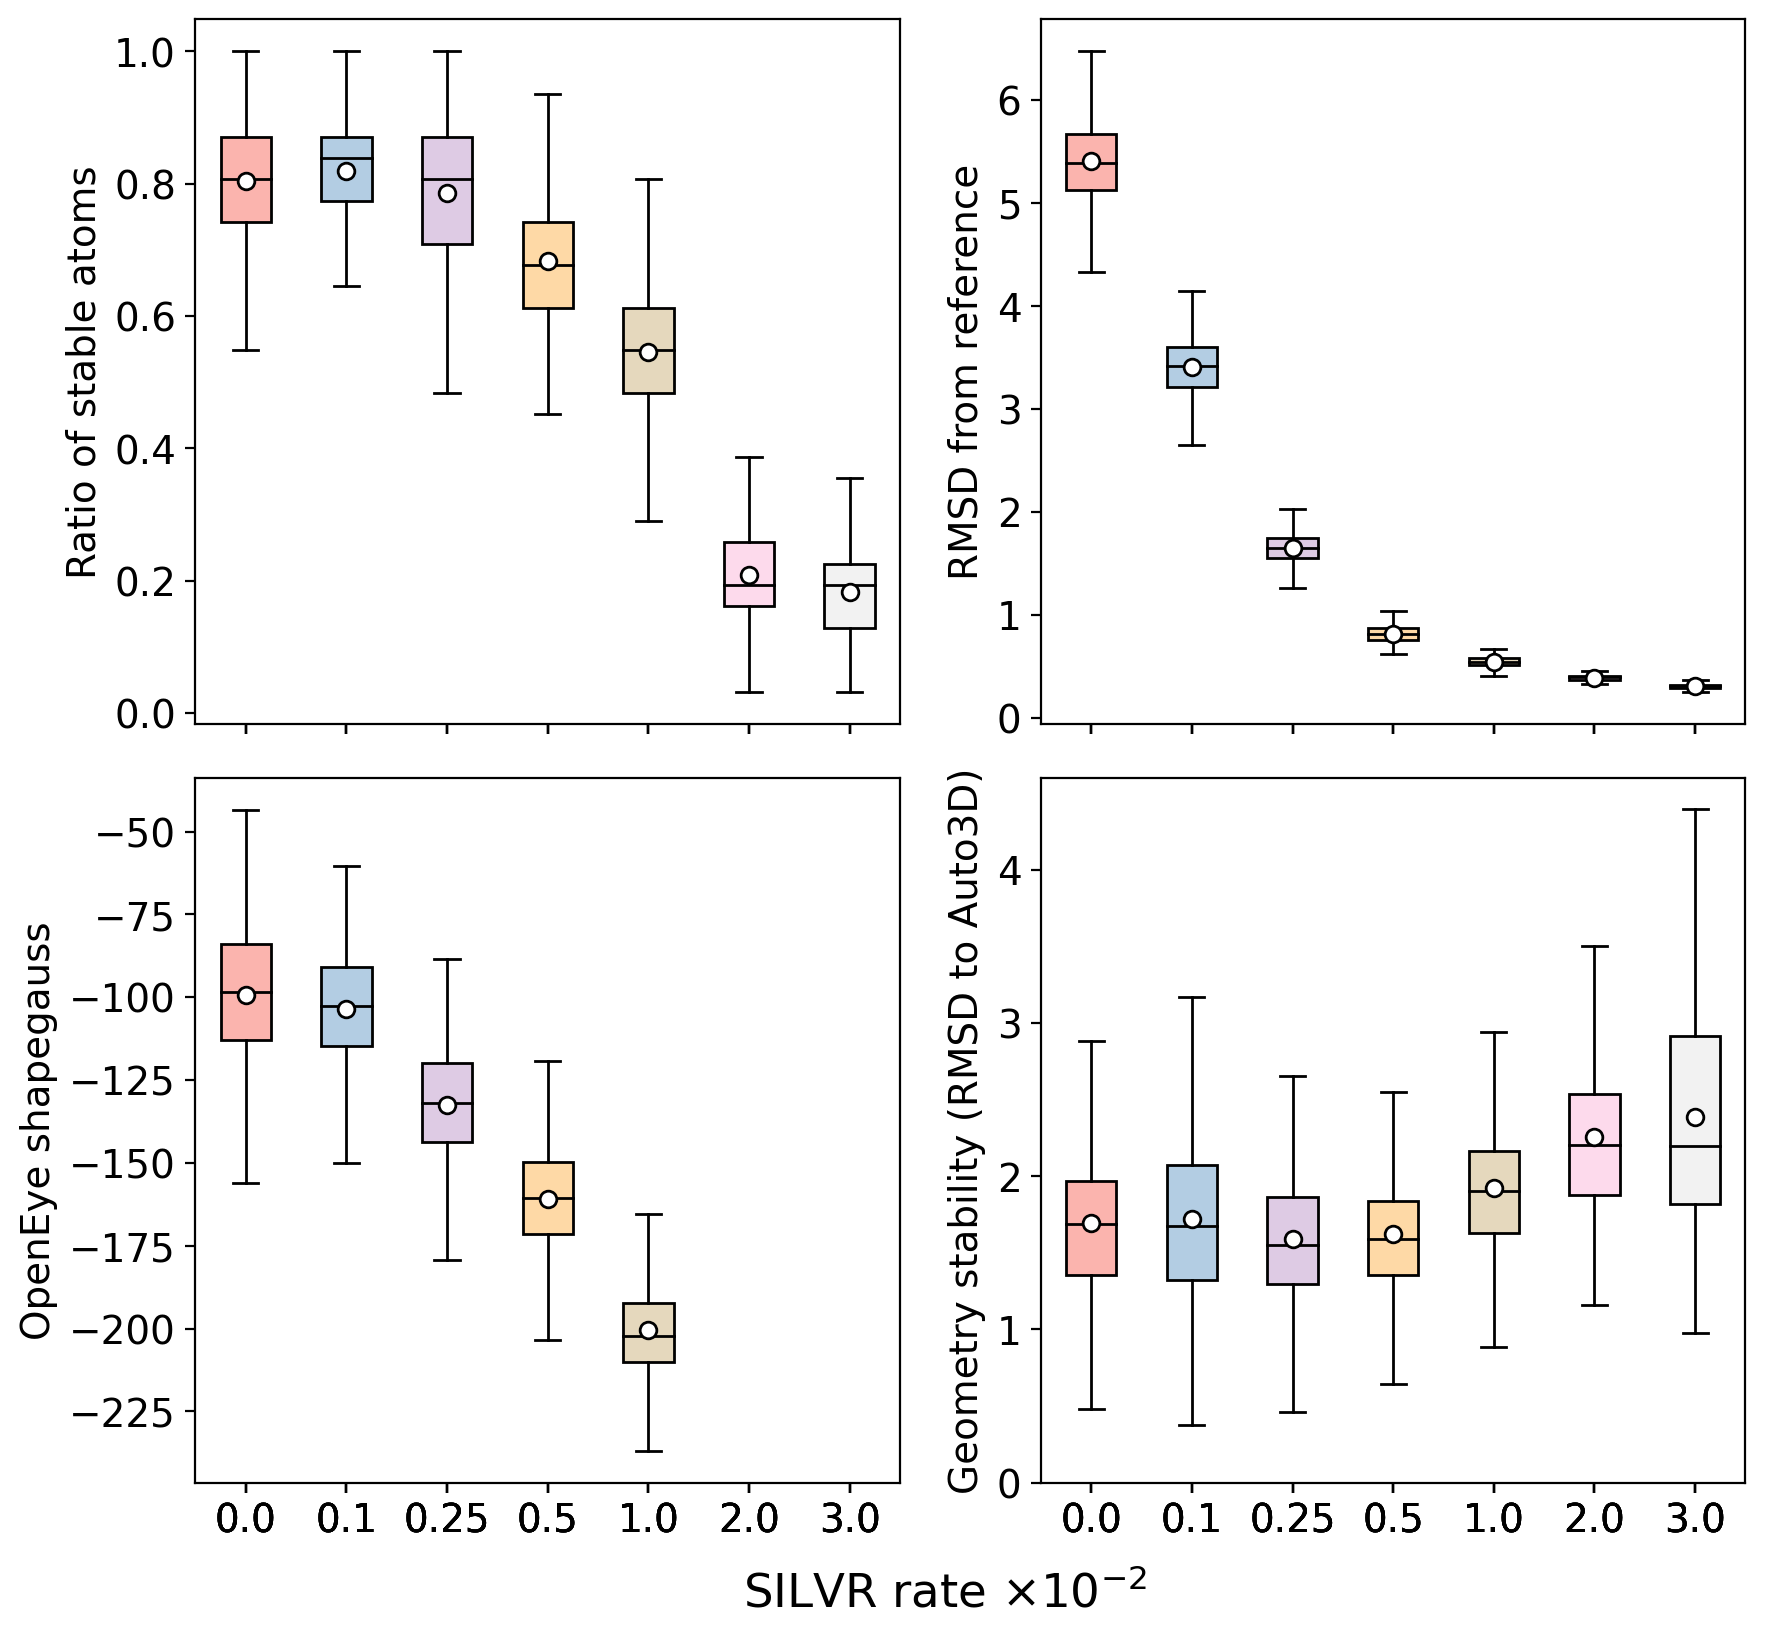

In [11]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np


#-----Data to plot---------
#These experiments need to be redone without the dummy atoms
ordered_exp_names = ["exp_22","exp_23","exp_24","exp_25","exp_26","exp_27","exp_28"] #list(exp_df.sort_values("silvr")["exp_id"])
#selected_df = df[df["is_fragmented"]==False]

#selected_df = df


#Make horizontal line black for readability!!!!!!!!


#-----Plot setup--------
#fig = plt.figure(figsize=(5, 5), dpi=80)
#ax = fig.add_subplot()

#plt.subplots(figsize=(6, 2))
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200,
                        #constrained_layout=True,
                        subplot_kw=dict(box_aspect=1),sharex=True)
#fig.tight_layout(pad=1)
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='white')

plt.rcParams['font.size'] = '14'
xlabel = r"SILVR rate $\times 10^{-2}$"

#-----plotting---------------


#since all plots share the same label
labels = get_plot_labels(df, ordered_exp_names)


#------------------[0,0] atom stability------------------
plotting_data = get_data_to_plot(df, ordered_exp_names, "stable_ratio")
box00 = axs[0,0].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[0,0].set(ylabel='Ratio of stable atoms')
#axs[0,0].set_title('A',loc='left')



#------------------[0,1] RMSD from reference------------------
plotting_data = get_data_to_plot(df, ordered_exp_names, "crude_rmsd")
box01 = axs[0,1].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[0,1].set(ylabel='RMSD from reference')
#axs[0,1].set_title('B',loc='left')




#------------------[1,0] shapegauss------------------
plotting_data = get_data_to_plot(df[df["shapegauss"]<200], ordered_exp_names, "shapegauss")

#Note: for SILVR=0.02 and 0.03 only 8 and 1 shapegauss value actually passes
#These are removed from the analysis as points are not representative
#plotting_data[-1] = [-50]
#plotting_data[-2] = [-50]
box10 = axs[1,0].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[1,0].set(ylabel='OpenEye shapegauss',
             #xlabel=xlabel
            )
#axs[1,0].set_title('C',loc='left')



#------------------[1,1] Geometric stability------------------
#!!!! Using rmsd column
plotting_data = get_data_to_plot(df[(df["is_fragmented"]==False) & (df["auto3d_rmsd"].notna())], ordered_exp_names, "auto3d_rmsd")
box11 = axs[1,1].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[1,1].set(ylabel='Geometry stability (RMSD to Auto3D)',
             #xlabel=xlabel
             yticks = [0, 1, 2,3,4],#Forcing the axis labels to be integers
            )
#axs[1,1].set_title('D',loc='left')



#------------------Make plot look nice------------------

#fig.text(0.5, 0, xlabel, ha='center')
plt.subplots_adjust(wspace=0.2, hspace=0.01)
fig.supxlabel(xlabel,y=0.07)

#----colors----
n_boxes = len(ordered_exp_names)
colors = cm.Pastel1(np.linspace(0, 1, n_boxes))


boxes = [box00,box01,box10,box11]
for box in boxes:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    for median in box['medians']:
        median.set_color('black')

In [12]:
df["qed"].notna().groupby(df["silvr"]).value_counts(True)[::2].mean()

0.9482071713147411

<AxesSubplot:title={'center':'Percentage of successful OB/RDKit reads'}, xlabel='SILVR rate', ylabel='Percentage of molecules\nread by RDKit'>

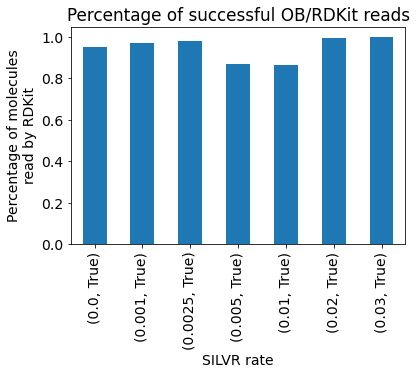

In [13]:
df["qed"].notna().groupby(df["silvr"]).value_counts(True)[::2].plot(kind="bar", title="Percentage of successful OB/RDKit reads",xlabel="SILVR rate", ylabel="Percentage of molecules\nread by RDKit")

In [14]:
df["auto3d_rmsd"].mean()

1.9541617565713383

In [15]:
df["auto3d_rmsd"].groupby(df["silvr"]).mean()

silvr
0.0000    1.697015
0.0010    1.717544
0.0025    1.593062
0.0050    1.621824
0.0100    1.921205
0.0200    2.256644
0.0300    2.382887
Name: auto3d_rmsd, dtype: float64

# All cells below this point should be deleted, however will keep in initial commit just incase.

# Preparing Molecules for Figures 

In [8]:
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from openbabel import pybel
from rdkit import Chem


def rdkit_fix_radicals(mol,add_h=False,flatten=False,uncharge=True):
    """
    Atoms with unfilled valance get radicals assigned.
    Openbabel will have assigned bond orders based on bond length.
    Here I assume all radical electrons should instead be hydrogen atoms
    """
    for atom in mol.GetAtoms():
        radicals = atom.GetNumRadicalElectrons()
        atom.SetNumRadicalElectrons(0)
        atom.SetNumExplicitHs(atom.GetNumExplicitHs() + radicals)

    if flatten:
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))

    if add_h:
        mol = Chem.AddHs(mol,addCoords=True)

    if uncharge:
        un = rdMolStandardize.Uncharger()
        mol = un.uncharge(mol)

    return mol


def xyz_to_mol_clean(xyz, add_h=True, flatten=False):
    """
    add_h - add RDKit hydrogens
    flatten - run Chem.MolFromSmiles(Chem.MolToSmiles(x)) such that geometry infromation is lost
    
    Sometimes these imports fail
    In these cases this function returns False
    """
    with open(xyz,"r") as readfile:
        xyz = readfile.read()
    try:
        mol_pybel = pybel.readstring("xyz", xyz)
        mol_mol2 = mol_pybel.write("mol2")

        #RDKit - clean radicals
        mol_rdkit = Chem.MolFromMol2Block(mol_mol2)
        mol_final = rdkit_fix_radicals(mol_rdkit, add_h=add_h, flatten=flatten)

        return mol_final
    
    except:
        return False
    
    
import py3Dmol

def show_reference(reference_file):
    with open(reference_file, "r") as readfile:
        file = readfile.read().split("\n")
        new_file = [file[0],file[1]]

        
        for line in file[2:]:
            new_file.append(" ".join(line.split()[:4]))
            
        new_file = "\n".join(new_file)
        
        with open("tmp.xyz", "w") as writefile:
            writefile.write(new_file)
            
        
        view = py3Dmol.view(query="tmp.xyz")  
        view.setStyle({'stick': {'color':'spectrum'}})
            
        return view.show()
    
    
def show_mol_file(mol_file):
    view = py3Dmol.view(query=mol_file)  
    view.setStyle({'stick': {'color':'spectrum'}})
    return view.show()

In [9]:
from rdkit.Chem import Draw
import os

def create_mol_figure_pack(molecule_path):
    mol_id = molecule_path.split("/")[-1].split(".")[0]
    exp_id = molecule_path.split("/")[-2]
    save_path = f"figures/{exp_id}_{mol_id}/"
    
    #-------Make directory in figures-------
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    else:
        print("Directory already exists")
        #raise Exception("Directory already exists")
        #return False
    
    
    #-------copy the molecule to figures-------
    os.system(f'cp {molecule_path} {save_path}{mol_id}.xyz') 
    
    #-------Save reference as XYZ-------
    reference_file = "/".join(molecule_path.split("/")[:2])+"/reference.sxyz"    
    with open(reference_file, "r") as readfile:
        file = readfile.read().split("\n")
        new_file = [file[0],file[1]]

        for line in file[2:]:
            new_file.append(" ".join(line.split()[:4]))
            
        new_file = "\n".join(new_file)
        
        with open(f"{save_path}reference.xyz", "w") as writefile:
            writefile.write(new_file)
        
    #-------get RDKit mol-------
    mol = xyz_to_mol_clean(molecule_path,flatten=True,add_h=False)
    
    #-------Save smiles string-------
    smiles_string = Chem.MolToSmiles(mol)
    with open(f"{save_path}smiles_string.txt", "w") as writefile:
        writefile.write(smiles_string)
    
    #-------Save 2D figure as svg-------
    Draw.MolToFile(Chem.MolFromSmiles(smiles_string), f"{save_path}mol_2d.svg")
    
    #-------Draw 2D figure as png-------
    Draw.MolToFile(Chem.MolFromSmiles(smiles_string), f"{save_path}mol_2d.png",size=(700,700))
    
    #-------OpenEye clean mol-------
    #This reads the molecule in openeye, adds protons and bond orders, then saves as sdf
    #Save as oe_cleaned.sdf

In [10]:
#clean molecules with openeye
#!Must be run in the open eye environment!

def oe_clean_mol(molecule_path):
    import sys

    from openeye import oechem
    from openeye import oedocking
    from openeye import oequacpac

    mol_id = molecule_path.split("/")[-1].split(".")[0]
    exp_id = molecule_path.split("/")[-2]
    output_file = f"figures/{exp_id}_{mol_id}/oe_cleaned.sdf"
    
    ifs = oechem.oemolistream()
    ifs.SetFormat(oechem.OEFormat_XYZ)
    ifs.open(molecule_path)
    
    mol = oechem.OEGraphMol()
    
    oechem.OEReadMolecule(ifs, mol)
    
    print("cleaning")
    oechem.OEAssignImplicitHydrogens(mol)
    oequacpac.OERemoveFormalCharge(mol)
    oequacpac.OEHypervalentNormalization(mol)
    oechem.OEAddExplicitHydrogens(mol)
    oequacpac.OESetNeutralpHModel(mol)        

    print("writing")
    ofs = oechem.oemolostream()
    ofs.open(output_file)
    oechem.OEWriteMolecule(ofs, mol)

    return 0

In [10]:
molecules = []

#Chunky ring system
molecules.append("experiments/exp_15/mol_2023_02_08_1217490_000.txt")

#Particularly clean ring system and looks quite drug like
#x0434_0A & x0305_0A
molecules.append("experiments/exp_13/mol_2023_02_08_1040511_000.txt")

#Odd looking molecule - however still interesting
molecules.append("experiments/exp_20/mol_2023_02_09_0145281_000.txt")

#Interesting - almost drug like
#x0434_0A & x0305_0A
molecules.append("experiments/exp_13/mol_2023_02_08_1016523_000.txt")


#Two disconected fragments
#experiments/exp_10/mol_2023_02_07_2338340_000.txt
molecules.append("experiments/exp_10/mol_2023_02_07_2338340_000.txt")



for mol_path in molecules:
    create_mol_figure_pack(mol_path)
    #oe_clean_mol(mol_path)

Directory already exists
Directory already exists
Directory already exists
Directory already exists
Directory already exists


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:41 tatoms:48 sratio:0.8541666666666666)

[13:35:07] Running Uncharger
[13:35:07] Running Uncharger
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:16 tatoms:27 sratio:0.5925925925925926)

[13:35:07] Removed negative charge.
[13:35:07] Removed negative charge.
[13:35:07] Running Uncharger
[13:35:07] Removed negative charge.
[13:35:07] Removed negative charge.
[13:35:07] Running Uncharger
[13:35:07] Removed negative charge.
[13:35:07] Removed negative charge.
[13:35:07] Removed negative charge.
[13:35:07] Running Uncharger
